In [1]:
from casacore.tables import table, taql
import numpy as np
import matplotlib.pyplot as plt
from RMtools_1D.do_RMsynth_1D import run_rmsynth
from astropy.coordinates import SkyCoord
from scipy import signal

/home/tho822/mambaforge/envs/arrakis310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from typing import NamedTuple
TRUE_3C286_PA = 33.0




class Stokes(NamedTuple):
    i: np.ndarray
    q: np.ndarray
    u: np.ndarray
    v: np.ndarray
    wave: np.ndarray
    freq: np.ndarray
    name: str
    theta: float

class Corrs(NamedTuple):
    xx: np.ndarray
    xy: np.ndarray
    yx: np.ndarray
    yy: np.ndarray
    wave: np.ndarray
    freq: np.ndarray
    name: str
    theta: float
    uvw: np.ndarray
    uvdist: np.ndarray


def corrs_to_stokes(corrs: Corrs, do_mean=True) -> Stokes:
    i = 0.5 * (corrs.xx.real + corrs.yy.real)
    q = 0.5 * (corrs.xx.real - corrs.yy.real)
    u = 0.5 * (corrs.xy.real + corrs.yx.real)
    v = -0.5 * (corrs.xy.imag - corrs.yx.imag)

    if do_mean:
        i = np.nanmean(i, axis=0)#.real
        q = np.nanmean(q, axis=0)#.real
        u = np.nanmean(u, axis=0)#.real
        v = np.nanmean(v, axis=0)#.real

    return Stokes(i, q, u, v, corrs.wave, corrs.freq, corrs.name, corrs.theta)

def get_pol_axis(ms_name):
    with table(f"{ms_name}/FEED") as tab:
        ang = tab.getcol("RECEPTOR_ANGLE")[0]
        print(f"Receptor angle for {ms_name} is {ang} rad or {np.rad2deg(ang)} deg")
        return -(ang[0] - np.pi/4)

def get_corrs(ms_name: str, datacolumn="CORRECTED_DATA") -> Corrs:
    theta = get_pol_axis(ms_name)

    with table(f"{ms_name}/SPECTRAL_WINDOW") as tab:
        freq = tab.getcol("CHAN_FREQ")[0]
        wave = 2.998e8 / freq
    
    with table(f"{ms_name}") as ms:
        # ms_data = ms.getcol(datacolumn)
        ms_data = taql(f"SELECT {datacolumn} FROM {ms_name} WHERE ANTENNA1 != ANTENNA2").getcol(datacolumn)
        # ms_flags = ms.getcol('FLAG')
        ms_flags = taql(f"SELECT FLAG FROM {ms_name} WHERE ANTENNA1 != ANTENNA2").getcol('FLAG')
        # ms_uvw = ms.getcol('UVW')
        ms_uvw = taql(f"SELECT UVW FROM {ms_name} WHERE ANTENNA1 != ANTENNA2").getcol('UVW')
        u,v,w = ms_uvw.T
        ms_uvdist = np.hypot(u, v)
        flags_reshape = ms_flags.reshape((-1,4))
        flags_reshape[np.any(flags_reshape, axis=1), :] = True
        ms_data[ms_flags] = np.nan

    # xx, xy, yx, yy = ms_data.T
    xx, xy, yx, yy = ms_data[...,0], ms_data[...,1], ms_data[...,2], ms_data[...,3]

    return Corrs(xx, xy, yx, yy, wave, freq, ms_name, theta, ms_uvw, ms_uvdist)

def plot_stokes(stokes: Stokes, title_extra: str = "") -> None:

    fig, ax_dict = plt.subplot_mosaic(
    """
    IP
    VA
    """,
    sharex=False,
    figsize=(16, 8),
    )

    # nu_g = stokes.freq / 1e9
    # nu_g_log = np.log10(nu_g)
    # pb_model_log = PB_scales[0] + \
    #             PB_scales[1] * nu_g_log + \
    #             PB_scales[2] * nu_g_log**2 + \
    #             PB_scales[3] * nu_g_log**3
    # pb_model = 10**(pb_model_log)

    ax_dict["I"].plot(stokes.freq, stokes.i, label="I", color="tab:green")
    # ax_dict["I"].plot(stokes.freq, pb_model, label="Perley+Butler", color="k", linestyle=":")
    ax_dict["I"].set_ylabel("Flux / Jy")

    ax_dict["V"].plot(stokes.freq, stokes.v / stokes.i, label="V", color="tab:orange")
    ax_dict["V"].set_xlabel("Frequency / Hz")
    ax_dict["V"].set_ylabel("Flux / Jy")
    # ax_dict["V"].set_ylim(-0.5, 0.5)

    ax_dict["P"].plot(stokes.wave**2, stokes.q, label="Q", color="tab:blue")
    ax_dict["P"].plot(stokes.wave**2, stokes.u, label="U", color="tab:red")
    ax_dict["P"].plot(stokes.wave**2, np.hypot(stokes.q, stokes.u), label="L", color="k")    
    ax_dict["P"].set_ylabel("Flux / Jy")

    # ax_dict["P"].plot(pb_pol_lsq, pb_model_q, label="Q PB", color="tab:blue", marker="x", linestyle="--")
    # ax_dict["P"].plot(pb_pol_lsq, pb_model_u, label="U PB", color="tab:red", marker="x", linestyle="--")
    # ax_dict["P"].plot(pb_pol_lsq, np.hypot(pb_model_q, pb_model_u), label="L PB", color="k", marker="x", linestyle="--")
    # ax_dict["P"].set_xlabel("$\lambda^2$ / m$^2$")


    ax_dict["A"].plot(stokes.wave**2, np.rad2deg(0.5*np.arctan2(stokes.u, stokes.q)), label="$\chi$", color="tab:purple")
    ax_dict["A"].axhline(TRUE_3C286_PA, color="k", linestyle="--", label="True PA")
    ax_dict["A"].set_ylim(-90, 90)
    ax_dict["A"].set_xlabel("$\lambda^2$ / m$^2$")
    ax_dict["A"].set_ylabel("Angle / deg")


    fig.legend()
    fig.suptitle(f"{stokes.name} - {np.rad2deg(stokes.theta):.2f} deg {title_extra}")
    plt.show()
    plt.tight_layout()

def plot_fraction(stokes: Stokes, title_extra: str = "") -> None:
    fig, ax_dict = plt.subplot_mosaic(
    """
    IP
    VA
    """,
    sharex=False,
    figsize=(16, 8),
    )

    # nu_g = stokes.freq / 1e9
    # nu_g_log = np.log10(nu_g)
    # pb_model_log = PB_scales[0] + \
    #             PB_scales[1] * nu_g_log + \
    #             PB_scales[2] * nu_g_log**2 + \
    #             PB_scales[3] * nu_g_log**3
    # pb_model = 10**(pb_model_log)

    # ax_dict["I"].plot(stokes.freq, stokes.i / pb_model, label="I/Perley+Butler", color="tab:green")
    ax_dict["I"].set_ylabel("Fraction")

    ax_dict["V"].plot(stokes.freq, stokes.v / stokes.i, label="V/I", color="tab:orange")
    ax_dict["V"].set_xlabel("Frequency / Hz")
    ax_dict["V"].set_ylabel("Fraction")

    ax_dict["P"].plot(stokes.wave**2, stokes.q / stokes.i, label="Q/I", color="tab:blue")
    ax_dict["P"].plot(stokes.wave**2, stokes.u / stokes.i, label="U/I", color="tab:red")
    ax_dict["P"].plot(stokes.wave**2, np.hypot(stokes.q, stokes.u) / stokes.i, label="L/I", color="k")
    # ax_dict["P"].plot(pb_pol_lsq, pb_model_pi/pb_model_i, label="L PB", color="k", linestyle="--", marker="x")
    # ax_dict["P"].plot(pb_pol_lsq, pb_model_q/pb_model_i, label="Q PB", color="tab:blue", linestyle="--", marker="x")
    # ax_dict["P"].plot(pb_pol_lsq, pb_model_u/pb_model_i, label="U PB", color="tab:red", linestyle="--", marker="x")
    ax_dict["P"].set_ylabel("Fraction")

    ax_dict["A"].plot(stokes.wave**2, np.rad2deg(0.5*np.arctan2(stokes.u, stokes.q)), label="$\chi$", color="tab:purple")
    ax_dict["A"].axhline(TRUE_3C286_PA, color="k", linestyle="--", label="True PA")
    ax_dict["A"].set_ylim(-90, 90)
    ax_dict["A"].set_xlabel("$\lambda^2$ / m$^2$")
    ax_dict["A"].set_ylabel("Angle / deg")


    fig.legend()
    fig.suptitle(f"{stokes.name} - {np.rad2deg(stokes.theta):.2f} deg {title_extra}")
    plt.show()
    plt.tight_layout()
    return fig, ax_dict

def og_rotation_matrix(corrs: Corrs) -> Corrs:
    # theta = np.rad2deg(corrs.theta)
    # print(f"{theta=}")
    # theta = np.deg2rad((-theta - 45.0))
    # print(f"{np.rad2deg(theta)=}")
    theta = corrs.theta
    correction_matrix = np.matrix(
        [
            [
                np.sin(2.0 * theta) + 1,
                np.cos(2.0 * theta),
                np.cos(2.0 * theta),
                1 - np.sin(2.0 * theta),
            ],
            [
                -np.cos(2.0 * theta),
                np.sin(2.0 * theta) + 1,
                np.sin(2.0 * theta) - 1,
                np.cos(2.0 * theta),
            ],
            [
                -np.cos(2.0 * theta),
                np.sin(2.0 * theta) - 1,
                np.sin(2.0 * theta) + 1,
                np.cos(2.0 * theta),
            ],
            [
                1 - np.sin(2.0 * theta),
                -np.cos(2.0 * theta),
                -np.cos(2.0 * theta),
                np.sin(2.0 * theta) + 1,
            ],
        ]
    )
    arr = np.array((corrs.xx, corrs.xy, corrs.yx, corrs.yy)).T
    cor_arr = np.einsum("ij,...j->...i", correction_matrix, arr)

    return Corrs(*cor_arr.T, corrs.wave, corrs.freq, corrs.name, corrs.theta)

def fix_ion(stokes: Stokes, true_angle: float) -> Stokes:
    pi = np.hypot( stokes.q,  stokes.u)
    new_stokes_q = pi * np.cos(2 * true_angle)
    new_stokes_u = pi * np.sin(2 * true_angle)

    return Stokes(stokes.i, new_stokes_q, new_stokes_u, stokes.v, stokes.wave, stokes.freq, stokes.name, stokes.theta)
    

Successful readonly open of default-locked table /scratch3/projects/spiceracs/racs_low3_flint/55799/SB55799.RACS_1326+32.beam4.ms/FEED: 12 columns, 1296 rows
Receptor angle for /scratch3/projects/spiceracs/racs_low3_flint/55799/SB55799.RACS_1326+32.beam4.ms is [1.57079633 3.14159265] rad or [ 90. 180.] deg
Successful readonly open of default-locked table /scratch3/projects/spiceracs/racs_low3_flint/55799/SB55799.RACS_1326+32.beam4.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful readonly open of default-locked table /scratch3/projects/spiceracs/racs_low3_flint/55799/SB55799.RACS_1326+32.beam4.ms: 25 columns, 55944 rows


/tmp/ipykernel_97814/926709453.py:37: RuntimeWarning: Mean of empty slice
  i = np.nanmean(i, axis=0)#.real
/tmp/ipykernel_97814/926709453.py:38: RuntimeWarning: Mean of empty slice
  q = np.nanmean(q, axis=0)#.real
/tmp/ipykernel_97814/926709453.py:39: RuntimeWarning: Mean of empty slice
  u = np.nanmean(u, axis=0)#.real


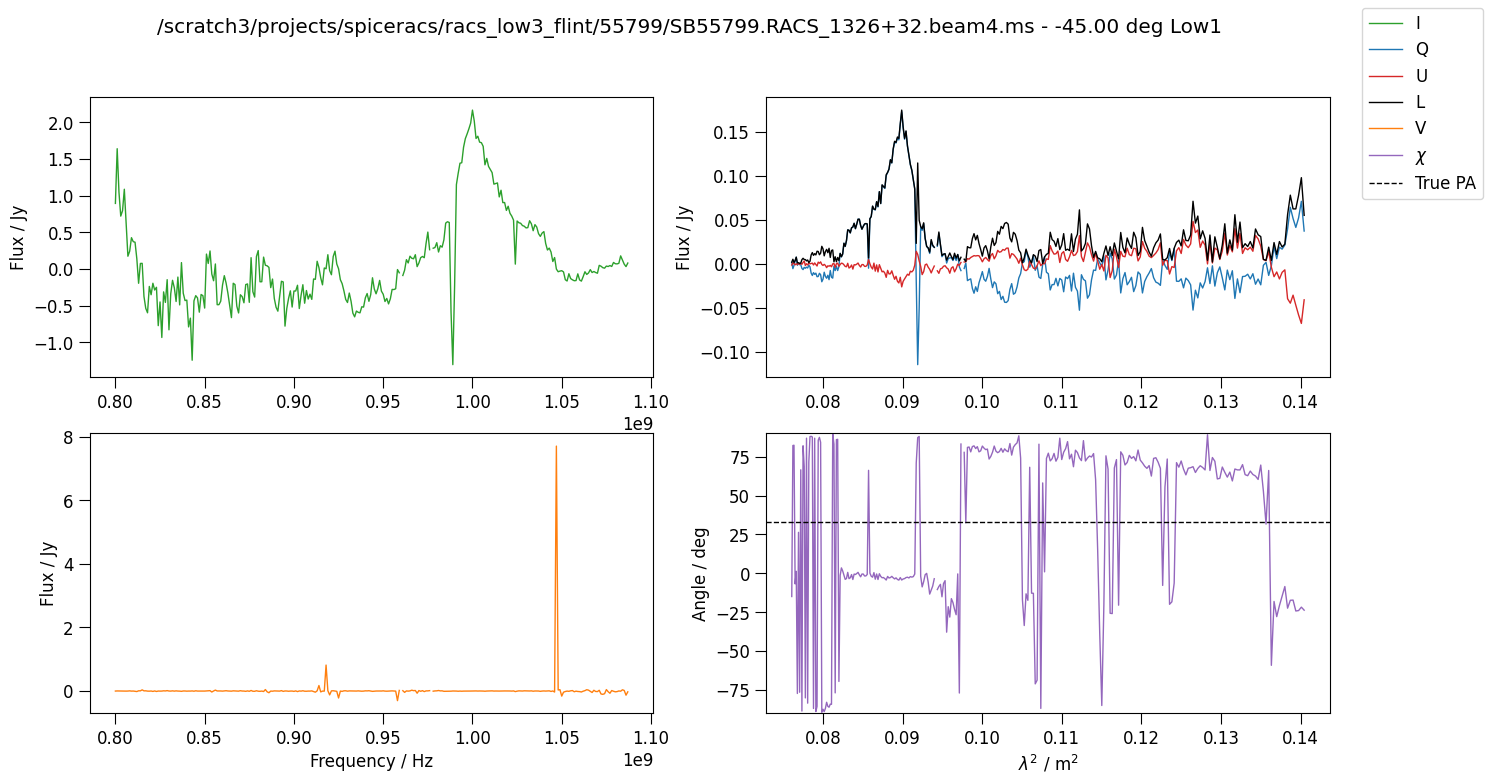

<Figure size 640x480 with 0 Axes>

In [5]:
low1 = "/scratch3/projects/spiceracs/racs_low3_flint/55799/SB55799.RACS_1326+32.beam4.ms"
low1_corrs = get_corrs(low1, datacolumn="CORRECTED_DATA")
low1_stokes = corrs_to_stokes(low1_corrs)
low1_full_stokes = corrs_to_stokes(low1_corrs, do_mean=False)
plot_stokes(low1_stokes, "Low1")

In [4]:
# low1 = "/scratch3/projects/spiceracs/racs_low1_test/8584/scienceData_SB8584_RACS_1357-18A.beam28_averaged_cal.leakage.split.ms"
# low_corrs = get_corrs(low1, datacolumn="DATA")
# low_stokes = corrs_to_stokes(low_corrs)
# plot_stokes(low_stokes, "Low1")

Successful readonly open of default-locked table /scratch3/projects/spiceracs/fresh_test_spiceracs/38959/SB38959.RACS_1357-18.beam28.ms/FEED: 12 columns, 1296 rows
Receptor angle for /scratch3/projects/spiceracs/fresh_test_spiceracs/38959/SB38959.RACS_1357-18.beam28.ms is [1.57079633 3.14159265] rad or [ 90. 180.] deg
Successful readonly open of default-locked table /scratch3/projects/spiceracs/fresh_test_spiceracs/38959/SB38959.RACS_1357-18.beam28.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful readonly open of default-locked table /scratch3/projects/spiceracs/fresh_test_spiceracs/38959/SB38959.RACS_1357-18.beam28.ms: 25 columns, 59940 rows


/tmp/ipykernel_31688/926709453.py:37: RuntimeWarning: Mean of empty slice
  i = np.nanmean(i, axis=0)#.real
/tmp/ipykernel_31688/926709453.py:38: RuntimeWarning: Mean of empty slice
  q = np.nanmean(q, axis=0)#.real
/tmp/ipykernel_31688/926709453.py:39: RuntimeWarning: Mean of empty slice
  u = np.nanmean(u, axis=0)#.real


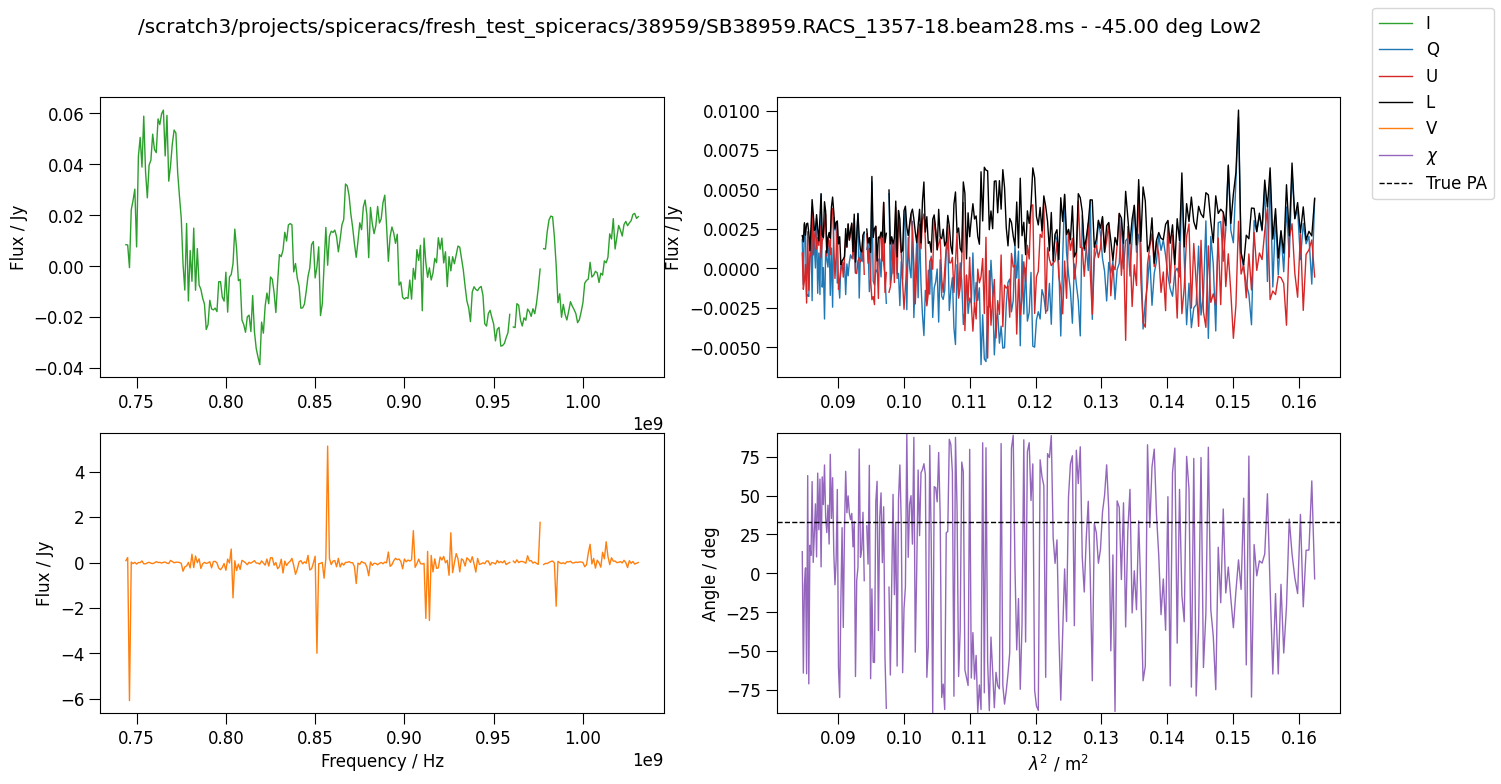

<Figure size 640x480 with 0 Axes>

In [25]:
low2 = "/scratch3/projects/spiceracs/fresh_test_spiceracs/38959/SB38959.RACS_1357-18.beam28.ms"
low2_corrs = get_corrs(low2)
low2_stokes = corrs_to_stokes(low2_corrs)
low2_full_stokes = corrs_to_stokes(low2_corrs, do_mean=False)
plot_stokes(low2_stokes, "Low2")

In [27]:
low1_stokes.i.shape

(288,)

(-0.07842343747615814,
 0.11000603139400482,
 -0.07842343747615814,
 0.11000603139400482)

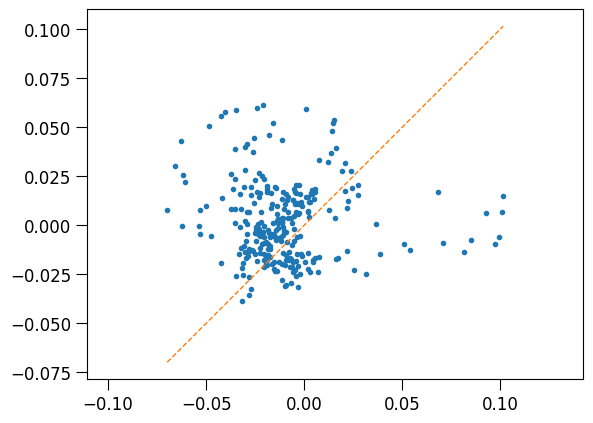

In [40]:
fig, ax = plt.subplots()
ax.plot(
    low1_stokes.i,
    low2_stokes.i,
    '.'
)
# Add 1:1 line
ax.plot(
    [np.nanmin(low1_stokes.i), np.nanmax(low1_stokes.i)],
    [np.nanmin(low1_stokes.i), np.nanmax(low1_stokes.i)],
    '--'
)
# Set axes equal
plt.axis('equal')

In [12]:
def moving_average(a, n=3):
    ret = np.nancumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

/tmp/ipykernel_31688/4245516533.py:3: RuntimeWarning: All-NaN slice encountered
  np.nanmax(low1_full_stokes.i, axis=1),
/tmp/ipykernel_31688/4245516533.py:13: RuntimeWarning: All-NaN slice encountered
  i_dec = moving_average(np.nanmax(low1_full_stokes.i, axis=1), dec_fac)


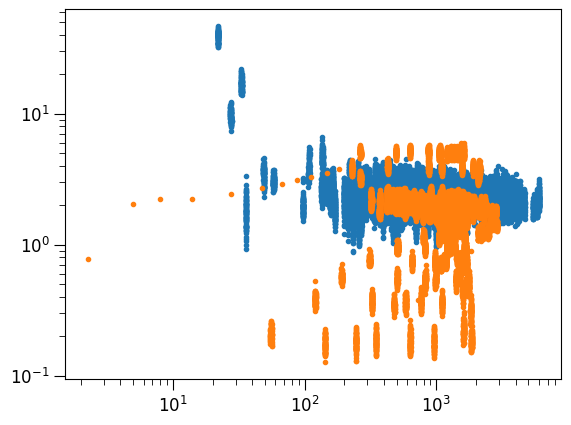

In [17]:
plt.plot(
    low1_corrs.uvdist,
    np.nanmax(low1_full_stokes.i, axis=1),
    '.'
)
# plt.plot(
#     low2_corrs.uvdist,
#     np.nanmax(low2_full_stokes.i, axis=1),
#     '.'
# )
# Apply smoothing with signal.decimate
dec_fac = 12
i_dec = moving_average(np.nanmax(low1_full_stokes.i, axis=1), dec_fac)
uv_dec = moving_average(low1_corrs.uvdist, dec_fac)
plt.plot(
    uv_dec,
    i_dec,
    '.'
)
plt.xscale("log")
plt.yscale("log")

In [18]:
low1_corrs.uvdist.shape

(59220,)

In [19]:
low1_pi = np.hypot(low1_stokes.q, low1_stokes.u)
low2_pi = np.hypot(low2_stokes.q, low2_stokes.u)

low1_pi_full = np.hypot(low1_full_stokes.q, low1_full_stokes.u)
low2_pi_full = np.hypot(low2_full_stokes.q, low2_full_stokes.u)

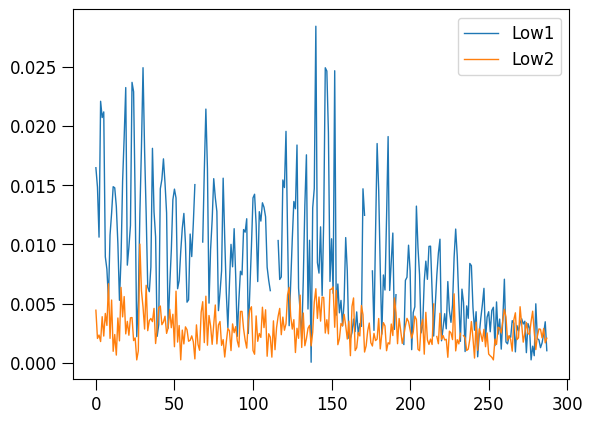

In [23]:
plt.plot(
    low1_pi,
    label="Low1"
)
plt.plot(
    low2_pi,
    label="Low2"
)
plt.legend()

/home/tho822/mambaforge/envs/casa/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


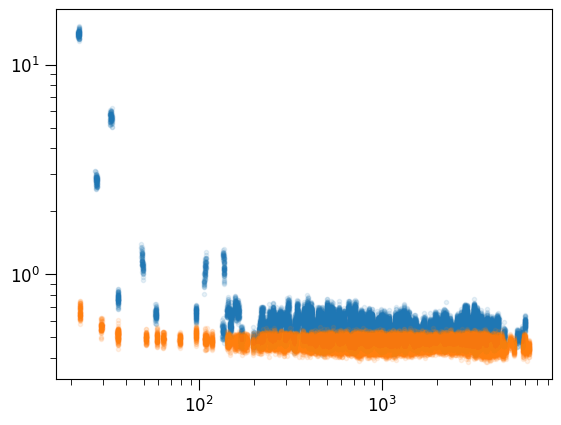

In [78]:
plt.plot(
    low1_corrs.uvdist,
    np.nanmedian(low1_pi_full, axis=1),
    '.',
    alpha=0.1,
    label="Low1"
)
plt.plot(
    low2_corrs.uvdist,
    np.nanmedian(low2_pi_full, axis=1),
    '.',
    alpha=0.1,
    label="Low2"
)
plt.xscale("log")
plt.yscale("log")

/home/tho822/mambaforge/envs/casa/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


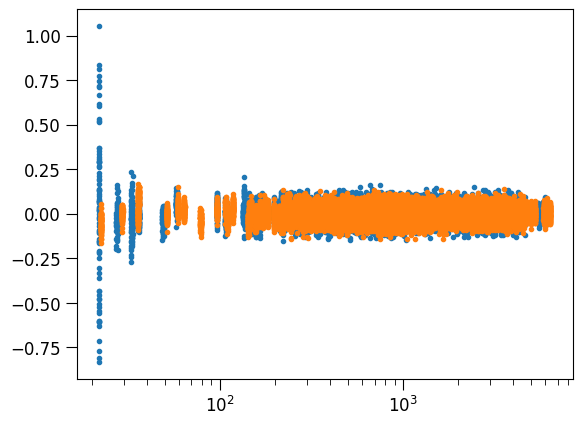

In [63]:
plt.plot(
    low1_corrs.uvdist,
    np.nanmedian(low1_full_stokes.q, axis=1),
    '.'
)
plt.plot(
    low2_corrs.uvdist,
    np.nanmedian(low2_full_stokes.q, axis=1),
    '.'
)
plt.xscale("log")

/home/tho822/mambaforge/envs/casa/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


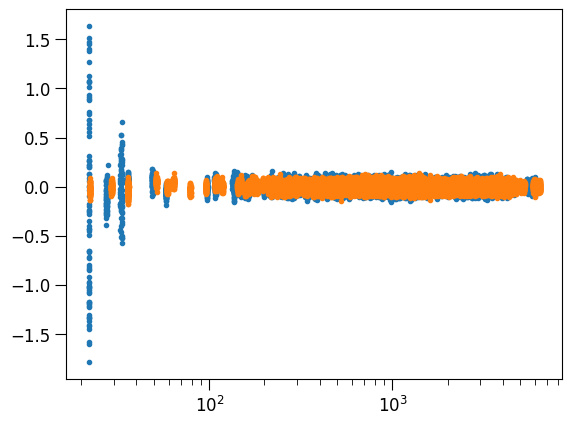

In [64]:
plt.plot(
    low1_corrs.uvdist,
    np.nanmedian(low1_full_stokes.u, axis=1),
    '.'
)
plt.plot(
    low2_corrs.uvdist,
    np.nanmedian(low2_full_stokes.u, axis=1),
    '.'
)
plt.xscale("log")

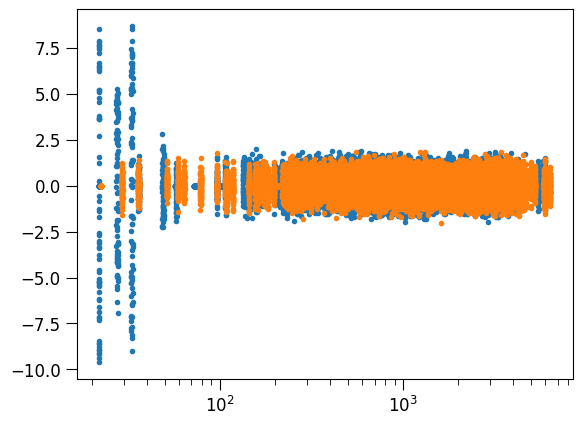

In [58]:
plt.plot(
    low1_corrs.uvdist,
    low1_full_stokes.v[:,0],
    '.'
)
plt.plot(
    low2_corrs.uvdist,
    low2_full_stokes.v[:,0],
    '.'
)
plt.xscale("log")